# Overview

This example demonstrates the use `tf.feature_column.crossed_column` on some simulated Atlanta housing price data. 
This spatial data is used primarily so the results can be easily visualized. 

These functions are designed primarily for categorical data, not to build interpolation tables. 

If you actually want to build smart interpolation tables in TensorFlow you may want to consider [TensorFlow Lattice](https://research.googleblog.com/2017/10/tensorflow-lattice-flexibility.html).

# Imports

In [1]:
import os
import subprocess
import tempfile

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/jasmeetbhatia/anaconda3/envs/tf19/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jasmeetbhatia/anaconda3/envs/tf19/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jasmeetbhatia/anaconda3/envs/tf19/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
assert tf.VERSION.split('.') >= ['1','4']

In [3]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 12, 6
mpl.rcParams['image.cmap'] = 'viridis'

In [4]:
logdir = tempfile.mkdtemp()

In [5]:
logdir

'/var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_'

# Start TensorBoard
The following command will kill all running TensorBoard processes, and start a new one monitoring to the above logdir. 

In [6]:
subprocess.Popen(['pkill','-f','tensorboard'])
subprocess.Popen(['tensorboard', '--logdir', logdir])

# Build Synthetic Data

In [7]:
# Define the grid
min_latitude = 33.641336
max_latitude = 33.887157
delta_latitude = max_latitude-min_latitude

min_longitude = -84.558798
max_longitude = -84.287259
delta_longitude = max_longitude-min_longitude

resolution = 100

In [8]:
# Use RandomState so the behavior is repeatable. 
R = np.random.RandomState(1)

In [9]:
# The price data will be a sum of Gaussians, at random locations.
n_centers = 20
centers = R.rand(n_centers, 2)  # shape: (centers, dimensions)

In [10]:
# Each Gaussian has a maximum price contribution, at the center.
# Price_
price_delta = 0.5+2*R.rand(n_centers)

In [11]:
# Each Gaussian also has a standard-deviation and variance.
std = 0.2*R.rand(n_centers)  # shape: (centers)
var = std**2

In [12]:
def price(latitude, longitude):
    # Convert latitude, longitude to x,y in [0,1]
    x = (longitude - min_longitude)/delta_longitude
    y = (latitude - min_latitude)/delta_latitude
    
    # Cache the shape, and flatten the inputs.
    shape = x.shape
    assert y.shape == x.shape
    x = x.flatten()
    y = y.flatten()
    
    # Convert x, y examples into an array with shape (examples, dimensions)
    xy = np.array([x,y]).T

    # Calculate the square distance from each example to each center.  
    components2 = (xy[:,None,:] - centers[None,:,:])**2  # shape: (examples, centers, dimensions)
    r2 = components2.sum(axis=2)  # shape: (examples, centers)
    
    # Calculate the z**2 for each example from each center.
    z2 = r2/var[None,:]
    price = (np.exp(-z2)*price_delta).sum(1)  # shape: (examples,)
    
    # Restore the original shape.
    return price.reshape(shape)

In [13]:
# Build the grid. We want `resolution` cells between `min` and `max` on each dimension
# so we need `resolution+1` evenly spaced edges. The centers are at the average of the
# upper and lower edge. 

latitude_edges = np.linspace(min_latitude, max_latitude, resolution+1)
latitude_centers = (latitude_edges[:-1] + latitude_edges[1:])/2

longitude_edges = np.linspace(min_longitude, max_longitude, resolution+1)
longitude_centers = (longitude_edges[:-1] + longitude_edges[1:])/2

latitude_grid, longitude_grid = np.meshgrid(
    latitude_centers,
    longitude_centers)

In [14]:
# Evaluate the price at each center-point
actual_price_grid = price(latitude_grid, longitude_grid)

price_min = actual_price_grid.min()
price_max = actual_price_grid.max()
price_mean = actual_price_grid.mean()
price_mean

0.8754787233855683

In [15]:
def show_price(price):
    plt.imshow(
        price, 
        # The color axis goes from `price_min` to `price_max`.
        vmin=price_min, vmax=price_max,
        # Put the image at the correct latitude and longitude.
        extent=(min_longitude, max_longitude, min_latitude, max_latitude), 
        # Make the image square.
        aspect = 1.0*delta_longitude/delta_latitude)

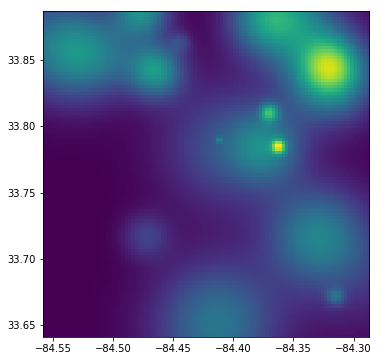

In [16]:
show_price(actual_price_grid)

# Build Datasets

In [17]:
# For test data we will use the grid centers.
test_features = {'latitude':latitude_grid.flatten(), 'longitude':longitude_grid.flatten()}
test_ds = tf.data.Dataset.from_tensor_slices((test_features, 
                                           actual_price_grid.flatten()))
test_ds = test_ds.cache().batch(512).prefetch(1)

# For training data we will use a set of random points.
train_latitude = min_latitude + np.random.rand(50000)*delta_latitude
train_longitude = min_longitude + np.random.rand(50000)*delta_longitude
train_price = price(train_latitude, train_longitude)

train_features = {'latitude':train_latitude, 'longitude':train_longitude}
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_price))
train_ds = train_ds.cache().repeat().shuffle(100000).batch(512).prefetch(1)

# A shortcut to build an `input_fn` from a `Dataset`
def in_fn(ds):
    return lambda : ds.make_one_shot_iterator().get_next()


# Generate a plot from an Estimator

In [18]:
def plot_est(est, ds = test_ds):
    # Create two plot axes
    actual, predicted = plt.subplot(1,2,1), plt.subplot(1,2,2)

    # Plot the actual price.
    plt.sca(actual)
    show_price(actual_price_grid.reshape(resolution, resolution))
    
    # Generate predictions over the grid from the estimator.
    pred =  est.predict(in_fn(ds))
    # Convert them to a numpy array.
    pred = np.fromiter((item['predictions'] for item in pred), np.float32)
    # Plot the predictions on the secodn axis.
    plt.sca(predicted)
    show_price(pred.reshape(resolution, resolution))

# Using `numeric_column` with DNNRegressor
Important: Pure categorical data doesn't the spatial relationships that make this example possible. Embeddings are a way your model can learn spatial relationships.

In [19]:
# Use `normalizer_fn` so that the model only sees values in [0, 1]
norm_latitude = lambda latitude:(latitude-min_latitude)/delta_latitude - 0.5
norm_longitude = lambda longitude:(longitude-min_longitude)/delta_longitude - 0.5

fc = [tf.feature_column.numeric_column('latitude', normalizer_fn = norm_latitude), 
      tf.feature_column.numeric_column('longitude', normalizer_fn = norm_longitude)]

# Build and train the Estimator
est = tf.estimator.DNNRegressor(
    hidden_units=[100,100], 
    feature_columns=fc, 
    model_dir = os.path.join(logdir,'DNN'))

est.train(in_fn(train_ds), steps = 5000)
est.evaluate(in_fn(test_ds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/DNN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18296b0710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints fo

{'average_loss': 0.015732035, 'global_step': 5000, 'loss': 7.8660173}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/DNN/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


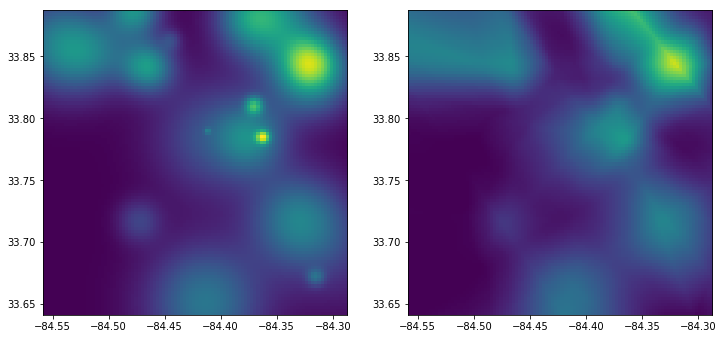

In [20]:
plot_est(est)

# Using `bucketized_column`

In [21]:
# Bucketize the latitude and longitude usig the `edges`
latitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('latitude'), 
    list(latitude_edges))

longitude_bucket_fc = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('longitude'),
    list(longitude_edges))

fc = [
    latitude_bucket_fc,
    longitude_bucket_fc]

# Build and train the Estimator.
est = tf.estimator.LinearRegressor(fc, model_dir = os.path.join(logdir,'separable'))
est.train(in_fn(train_ds), steps = 5000)
est.evaluate(in_fn(test_ds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/separable', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x182422f860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoi

{'average_loss': 0.24988684, 'global_step': 5000, 'loss': 124.94342}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/separable/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


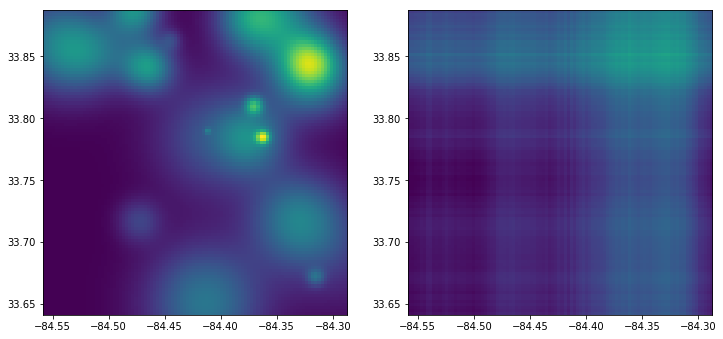

In [22]:
plot_est(est)

# Using `crossed_column` on its own.
The single-cell "holes" in the figure are caused by cells which do not contain examples.

In [23]:
# Cross the bucketized columns, using 5000 hash bins (for an average weight sharing of 2).
crossed_lat_lon_fc = tf.feature_column.crossed_column(
    [latitude_bucket_fc, longitude_bucket_fc], int(5e3))

fc = [crossed_lat_lon_fc]

# Build and train the Estimator.
est = tf.estimator.LinearRegressor(fc, model_dir=os.path.join(logdir, 'crossed'))

est.train(in_fn(train_ds), steps = 5000)
est.evaluate(in_fn(test_ds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/crossed', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18292e7390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoint

{'average_loss': 0.3270907, 'global_step': 5000, 'loss': 163.54536}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/crossed/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


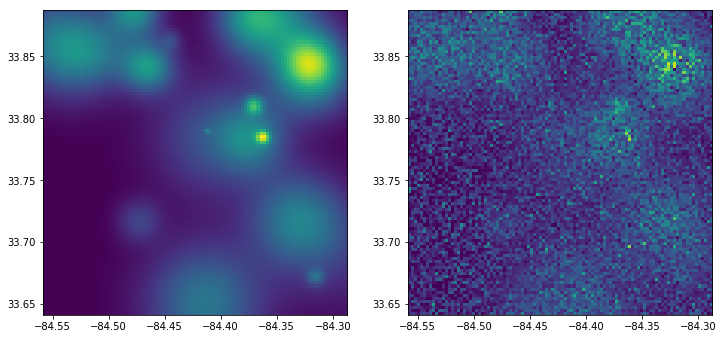

In [24]:
plot_est(est)

# Using raw categories with `crossed_column` 
The model generalizes better if it also has access to the raw categories, outside of the cross. 

In [25]:
fc = [
    latitude_bucket_fc,
    longitude_bucket_fc,
    crossed_lat_lon_fc]

# Build and train the Estimator.
est = tf.estimator.LinearRegressor(fc, model_dir=os.path.join(logdir, 'both'))
est.train(in_fn(train_ds), steps = 5000)
est.evaluate(in_fn(test_ds))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/both', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10ad5b4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints fo

{'average_loss': 0.14757521, 'global_step': 5000, 'loss': 73.78761}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/s3/bf5fc9dd1c30gzgwqf9_h55w00hby8/T/tmpsti2u_y_/both/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


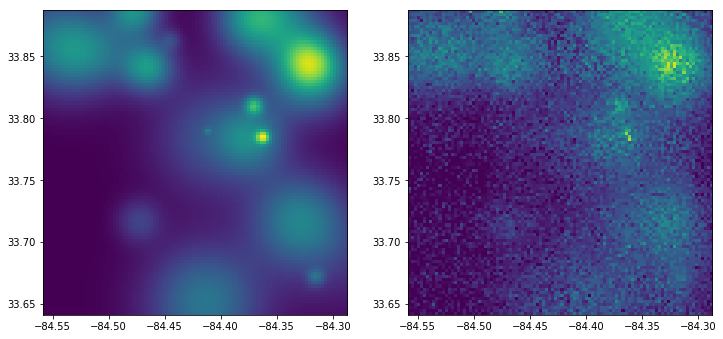

In [26]:
plot_est(est)

# Open TensorBoard

In [30]:
%%html
<iframe width="900" height="800" src="http://0.0.0.0:6006#scalars&_smoothingWeight=0.85" frameborder="0"></iframe>